## **IMPORT LIBRARY**

In [1]:
!pip install transformers
! pip install --upgrade scikit-learn
! pip install tqdm
! pip install wordcloud

In [2]:
! pip install scikit-learn==0.24.2
! pip install imbalanced-learn==0.8.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4


In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
import pandas as pd
import numpy as np
import string
import re
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### **LOAD DATASET**

In [6]:
df = pd.read_csv('data ulasan terbaru.csv')

### **PREPROCESSING**

In [7]:
# Menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    return text_no_emoticons

# Mengubah menjadi huruf kecil
df['content'] = df['content'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))
# Menampilkan hasil
print(df.head())

                                    content  label
0                             qaraa mantapp      2
1                                     bagus      2
2                           good aplication      2
3             aplikasi bagus sangat berguna      2
4  aplikasi al quran terlengkap dan terbaik      2


### **Wordcloud**

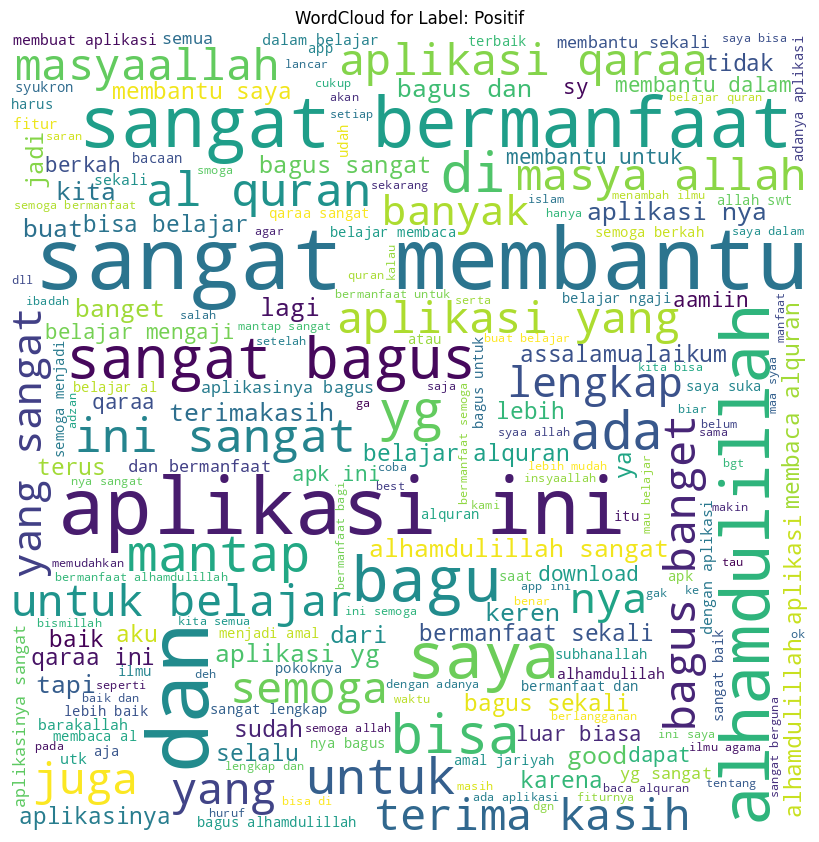

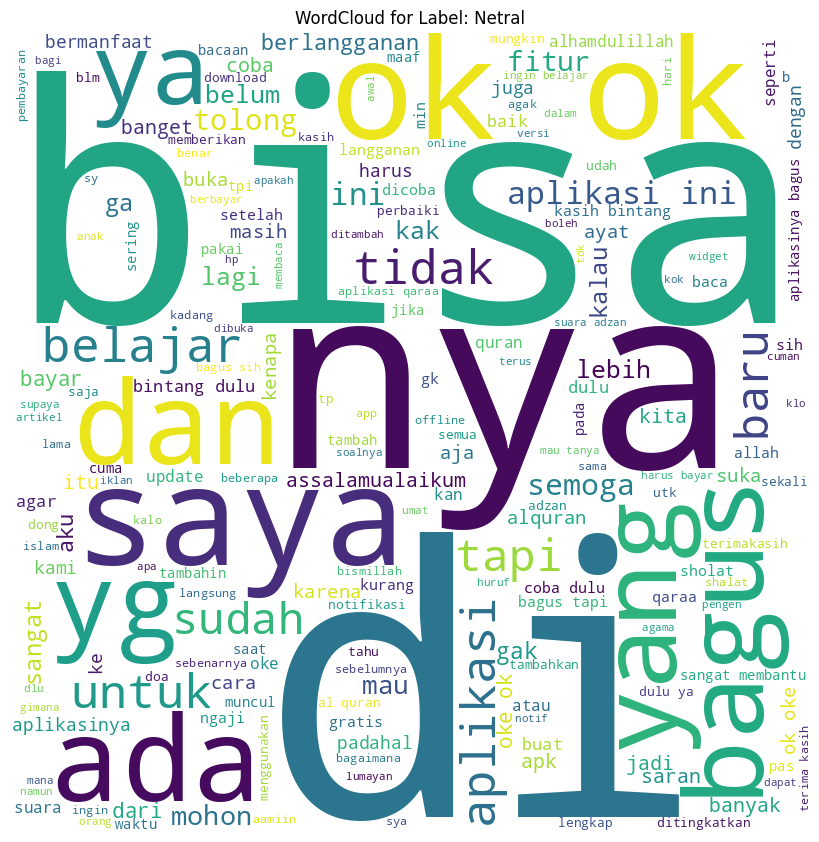

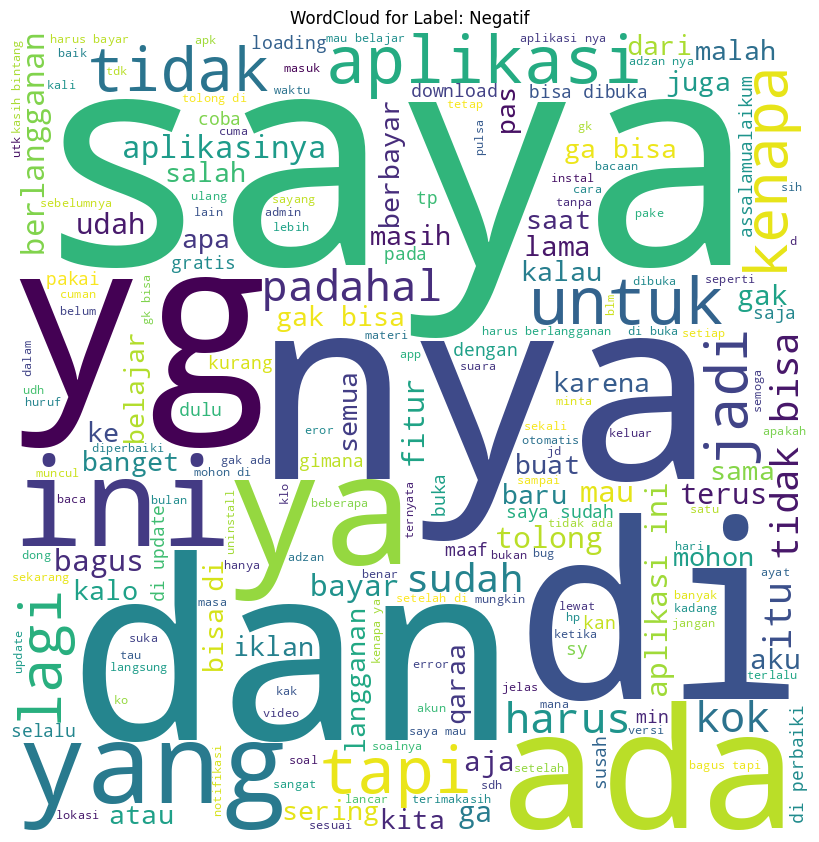

In [8]:
# Membuat WordCloud untuk setiap Label
# Identifikasi label
label_mapping = {2: 'Positif', 1: 'Netral', 0: 'Negatif'}

labels = df['label'].unique()
for label in labels:
    text = ' '.join(df[df['label'] == label]['content'].values)
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'WordCloud for Label: {label_mapping[label]}')
    plt.show()

### **TRAINING/VALIDATION SPLIT**

In [9]:
# Bagi dataset menjadi data train (60%) dan data sisa (40%)
# X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.4, random_state=17, stratify=df.label.values)

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)


In [10]:
# Bagi dataset menjadi data train (80%) dan data sisa (20%)
X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=17, stratify=df.label.values)

# Gunakan SMOTE pada data pelatihan
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(-1, 1), y_train)

# Bentuk kembali data yang telah diresample
X_train_resampled = X_train_resampled.flatten()

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)

# Tampilkan jumlah masing-masing set data
print("Jumlah data pelatihan:", len(X_train))
print("Jumlah data validasi:", len(X_val))
print("Jumlah data pengujian:", len(X_test))


Jumlah data pelatihan: 7950
Jumlah data validasi: 994
Jumlah data pengujian: 994


In [11]:
# Cetak distribusi kelas sebelum SMOTE
print("Distribusi Kelas Sebelum SMOTE:")
print(df.iloc[X_train]['label'].value_counts())

print("Jumlah Sampel Setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribusi Kelas Sebelum SMOTE:
label
2    6696
0     805
1     449
Name: count, dtype: int64
Jumlah Sampel Setelah SMOTE:
2    6696
1    6696
0    6696
Name: count, dtype: int64


In [12]:
# Tambahkan kolom baru "data_type" untuk data test
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_test, 'data_type'] = 'test'

In [13]:
# Mengelompokkan nilai kolom 'data_type' di baris yang sesuai dengan indeks X_train, X_val, dan X_test pada DataFrame

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'

### **Loading Tokenizer and Encoding our Data**

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
print(df.head())

                                    content  label data_type
0                             qaraa mantapp      2     train
1                                     bagus      2     train
2                           good aplication      2       val
3             aplikasi bagus sangat berguna      2     train
4  aplikasi al quran terlengkap dan terbaik      2     train


In [16]:
# Menggunakan tokenizer untuk mengkodekan data setelah SMOTE
encoded_data_train_resampled = tokenizer.batch_encode_plus(
    df.loc[X_train_resampled, 'content'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data validasi
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data uji
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Mendapatkan input_ids, attention_masks, dan labels untuk data setelah SMOTE
input_ids_train_resampled = encoded_data_train_resampled['input_ids']
attention_masks_train_resampled = encoded_data_train_resampled['attention_mask']
labels_train_resampled = torch.tensor(df.loc[X_train_resampled, 'label'].values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data validasi
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data uji
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
# Membuat objek TensorDataset dari fitur dan label untuk data setelah SMOTE
dataset_train_resampled = TensorDataset(input_ids_train_resampled, attention_masks_train_resampled, labels_train_resampled)

# Membuat objek TensorDataset dari fitur dan label untuk data validasi
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Membuat objek TensorDataset dari fitur dan label untuk data uji
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)


In [18]:
len(dataset_train_resampled)

20088

In [19]:
len(dataset_val)

994

In [20]:
len(dataset_test)

994

### **SETTING UP BERT PRE-TRAINED MODEL**

In [21]:
# Membuat kode unik dari kolom label

possible_labels = df.label.unique()

In [22]:
# Mengonversi label ke kelas index

label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [23]:
# Jumlah kelas dalam tugas klasifikasi
num_labels = len(label_dict)

# Menginisialisasi model BERT untuk klasifikasi urutan
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
params = list(model.named_parameters())  # Mendapatkan Daftar Nama Parameter

print('The BERT model has {:} different named parameters.\n'.format(len(params)))  # Mencetak Jumlah Parameter

print('=== Embedding Layer ===\n')  # Mencetak informasi tentang parameter di lapisan embedding.
for p in params[0:5]:  # Pilih hanya lima parameter pertama untuk contoh, dapat disesuaikan.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== Transformer ===\n')  # Mencetak informasi tentang parameter di lapisan transformer.
for p in params[5:]:  # Mulai dari parameter ke-6 karena BERT memiliki lapisan embedding dan transformer.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=== Transformer ===

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert

### **CREATING DATA LOADERS**
membuat objek DataLoader untuk mengatur data pelatihan dan validasi dalam bentuk batch.

In [25]:
batch_size = 64

# DataLoader untuk data pelatihan
# DataLoader untuk data setelah SMOTE
dataloader_train_resampled = DataLoader(dataset_train_resampled,
                                        sampler=RandomSampler(dataset_train_resampled),
                                        batch_size=batch_size)

# DataLoader untuk data validasi
dataloader_validation = DataLoader(dataset_val,
                                   sampler=RandomSampler(dataset_val),
                                   batch_size=batch_size)

# DataLoader untuk data uji
dataloader_test = DataLoader(dataset_test,
                              sampler=RandomSampler(dataset_test),
                              batch_size=batch_size)

### **SETTING UP OPTIMISER AND SCHEDULER**
mempersiapkan algoritma optimasi AdamW untuk mengoptimalkan (memperbarui) parameter-parameter model selama pelatihan.

In [26]:
optimizer = AdamW(model.parameters(), # Mendapatkan semua parameter model yang memerlukan pembaruan selama pelatihan
                  lr=1e-5, # Menentukan tingkat pembelajaran (learning rate) untuk optimizer.
                  eps=1e-8) # Menentukan epsilon (ε) atau nilai kecil yang digunakan untuk mencegah pembagian dengan nol dalam algoritma AdamW.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
epochs = 15

# Scheduler untuk data pelatihan
scheduler_train = get_linear_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=0,
                                                  num_training_steps=len(dataloader_train_resampled)*epochs)

# Scheduler untuk data validasi
scheduler_val = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_validation)*epochs)

# Scheduler untuk data uji
num_training_steps_test = len(dataloader_test) * epochs
scheduler_test = get_linear_schedule_with_warmup(optimizer,
                                                 num_warmup_steps=0,
                                                 num_training_steps=num_training_steps_test)


### **DEFINING OUR PERFORMANCE METRICS**

In [28]:
# Fungsi precision_score_func digunakan untuk menghitung skor presisi (precision).
def precision_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakannya
    return precision_score(labels_flat, preds_flat, average='macro')  # Menghitung presisi dengan skala rata-rata 'macro'.

# Fungsi accuracy_score_func digunakan untuk menghitung skor akurasi (accuracy).
def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return accuracy_score(labels_flat, preds_flat)  # Menghitung akurasi.

# Fungsi recall_score_func digunakan untuk menghitung skor recall.
def recall_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return recall_score(labels_flat, preds_flat, average='macro')  # Menghitung recall dengan skala rata-rata 'macro'.

# Fungsi f1_score_func digunakan untuk menghitung skor F1-score.
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()  # Mendapatkan kelas prediksi dari vektor prediksi
    labels_flat = labels.flatten()  # Mengambil label sebenarnya dan meratakan mereka
    return f1_score(labels_flat, preds_flat, average='weighted')  # Menghitung F1-score dengan skala rata-rata 'weighted'.

# Fungsi-fungsi evaluasi tambahan untuk data uji (pengujian).
# Fungsi-fungsi ini serupa dengan yang sebelumnya, tetapi digunakan untuk pengujian (testing) model.
def precision_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def recall_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')

def f1_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [29]:
def accuracy_per_class_test(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}  # Mengembalikan kamus invers dari kamus label_dict

    # Mengambil prediksi dan label dalam bentuk flat array
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels.flat):  # Iterasi melalui setiap label unik dalam labels
        # Mengambil prediksi dan label yang sesuai dengan label saat ini
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        # Mencetak akurasi per kelas
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')


### **CREATING OUR TRAINING LOOP**

In [30]:
# Periksa ketersediaan GPU
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [31]:
# Menentukan perangkat yang digunakan untuk melatih atau menggunakan model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [32]:
# Fungsi evaluate digunakan untuk mengevaluasi model pada data validasi.
def evaluate(dataloader_val):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_val_total = 0  # Inisialisasi total loss untuk data validasi
    predictions, true_vals = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_val:  # Loop melalui batch data validasi
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data validasi
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_val_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_val_avg = loss_val_total / len(dataloader_val)  # Menghitung rata-rata loss pada data validasi

    predictions = np.concatenate(predictions, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals = np.concatenate(true_vals, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_val_avg, predictions, true_vals  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya

# Fungsi evaluate_test digunakan untuk mengevaluasi model pada data pengujian.
def evaluate_test(dataloader_test):
    model.eval()  # Mengatur model dalam mode evaluasi, menonaktifkan training dropout dan perubahan berat
    loss_test_total = 0  # Inisialisasi total loss untuk data pengujian
    predictions_test, true_vals_test = [], []  # Inisialisasi list untuk menyimpan prediksi dan label yang sebenarnya

    for batch in dataloader_test:  # Loop melalui batch data pengujian
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}  # Mendapatkan input dan label dari batch
        with torch.no_grad():  # Memastikan perhitungan tidak menyimpan gradien
            outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pengujian
        loss = outputs.loss  # Mendapatkan loss dari hasil prediksi
        logits = outputs.logits  # Mendapatkan logit (skor) dari hasil prediksi

        loss_test_total += loss.item()  # Menambahkan loss dari batch ke total loss
        logits = logits.detach().cpu().numpy()  # Mengambil hasil prediksi dan mengkonversinya menjadi array NumPy
        labels_ids = inputs['labels'].cpu().numpy()  # Mengambil label yang sebenarnya dan mengkonversinya menjadi array NumPy
        predictions_test.append(logits)  # Menyimpan hasil prediksi dalam list
        true_vals_test.append(labels_ids)  # Menyimpan label yang sebenarnya dalam list

    loss_test_avg = loss_test_total / len(dataloader_test)  # Menghitung rata-rata loss pada data pengujian

    predictions_test = np.concatenate(predictions_test, axis=0)  # Menggabungkan hasil prediksi dari semua batch
    true_vals_test = np.concatenate(true_vals_test, axis=0)  # Menggabungkan label yang sebenarnya dari semua batch

    return loss_test_avg, predictions_test, true_vals_test  # Mengembalikan rata-rata loss, hasil prediksi, dan label yang sebenarnya


In [33]:
training_status = []  # Inisialisasi list untuk menyimpan status pelatihan

# Inisialisasi list untuk mengumpulkan data metrik
train_losses = []
val_losses = []
test_losses = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
test_accuracy_scores = []

# Loop melalui sejumlah epoch yang ditentukan
for epoch_i in tqdm(range(0, epochs)):
    model.train()  # Model dalam mode pelatihan
    loss_train_total = 0  # Inisialisasi total loss pelatihan

    # Bar progress untuk menampilkan perkembangan pelatihan
    progress_bar = tqdm(dataloader_train_resampled, desc='Epoch {:1d}'.format(epoch_i + 1), leave=True, disable=False)

    # Loop melalui batch data pelatihan
    for batch in progress_bar:
        model.zero_grad()  # Mengatur gradien pada nol
        batch = tuple(b.to(device) for b in batch)  # Mengirim data batch ke perangkat (device) yang sesuai
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data pelatihan
        loss = outputs[0]  # Mendapatkan loss dari hasil prediksi
        loss_train_total += loss.item()
        loss.backward()  # Menghitung gradien loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Menggunakan clipping gradient untuk mencegah gradien eksplosif
        optimizer.step()  # Melakukan optimisasi dengan langkah yang dihitung
        scheduler_train.step()  # Menggunakan scheduler_train untuk pelatihan (misalnya, penurunan suku learning rate)
        progress_bar.set_postfix({'training_loss': '{0:.2f}'.format(loss.item() / len(batch))})  # Menampilkan loss saat ini

    # Menyimpan model setiap epoch
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch_i}.model')

    tqdm.write(f'\nEpoch {epoch_i}')
    loss_train_avg = loss_train_total / len(dataloader_train_resampled)
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluasi model pada data validasi
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_precision = precision_score_func(predictions, true_vals)
    val_recall = recall_score_func(predictions, true_vals)
    val_accuracy = accuracy_score_func(predictions, true_vals)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score: {val_f1}')
    tqdm.write(f'Precision Score: {val_precision}')
    tqdm.write(f'Recall Score: {val_recall}')
    tqdm.write(f'Accuracy Score: {val_accuracy}')

    # Evaluasi model pada data uji
    test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)
    test_f1 = f1_score_func_test(test_predictions, test_true_vals)
    test_precision = precision_score_func_test(test_predictions, test_true_vals)
    test_recall = recall_score_func_test(test_predictions, test_true_vals)
    test_accuracy = accuracy_score_func_test(test_predictions, test_true_vals)

    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'Test F1 Score: {test_f1}')
    tqdm.write(f'Test Precision Score: {test_precision}')
    tqdm.write(f'Test Recall Score: {test_recall}')
    tqdm.write(f'Test Accuracy Score: {test_accuracy}')

    # Menambahkan metrik pelatihan, validasi, dan uji ke dalam list
    train_losses.append(loss_train_total / len(dataloader_train_resampled))
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    f1_scores.append(val_f1)
    precision_scores.append(val_precision)
    recall_scores.append(val_recall)
    accuracy_scores.append(val_accuracy)
    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_accuracy_scores.append(test_accuracy)

    # Menambahkan status pelatihan ke dalam daftar
    training_status.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'F1 Score': val_f1,
            'Precision Score': val_precision,
            'Recall Score': val_recall,
            'Accuracy Score': val_accuracy,
            'Test Loss': test_loss,
            'Test F1 Score': test_f1,
            'Test Precision Score': test_precision,
            'Test Recall Score': test_recall,
            'Test Accuracy Score': test_accuracy
        }
    )

  0%|          | 0/15 [10:07<?, ?it/s]


Epoch 0
Training loss: 0.5573084987462706


  0%|          | 0/15 [10:17<?, ?it/s]

Validation loss: 0.3158482452854514
F1 Score: 0.9127828124363322
Precision Score: 0.7226724217952288
Recall Score: 0.887767866648416
Accuracy Score: 0.9014084507042254


  7%|▋         | 1/15 [10:28<2:26:32, 628.06s/it]

Test loss: 0.36027115769684315
Test F1 Score: 0.9019874033773028
Test Precision Score: 0.7120021539259289
Test Recall Score: 0.8911863589679095
Test Accuracy Score: 0.8903420523138833



  7%|▋         | 1/15 [20:44<2:26:32, 628.06s/it]


Epoch 1
Training loss: 0.2252467566401146


  7%|▋         | 1/15 [20:53<2:26:32, 628.06s/it]

Validation loss: 0.2301119351759553
F1 Score: 0.9386760614765953
Precision Score: 0.7970487605313573
Recall Score: 0.9347349033418446
Accuracy Score: 0.9346076458752515


 13%|█▎        | 2/15 [21:04<2:17:10, 633.13s/it]

Test loss: 0.29179356526583433
Test F1 Score: 0.9217161897092988
Test Precision Score: 0.7599328339949961
Test Recall Score: 0.921688151082605
Test Accuracy Score: 0.9154929577464789



 13%|█▎        | 2/15 [31:22<2:17:10, 633.13s/it]


Epoch 2
Training loss: 0.13881377469463524


 13%|█▎        | 2/15 [31:31<2:17:10, 633.13s/it]

Validation loss: 0.2140172888757661
F1 Score: 0.9447116712011435
Precision Score: 0.818911976911977
Recall Score: 0.9486309037969849
Accuracy Score: 0.9416498993963782


 20%|██        | 3/15 [31:42<2:07:01, 635.10s/it]

Test loss: 0.24411794915795326
Test F1 Score: 0.9393325344384227
Test Precision Score: 0.8067741008572386
Test Recall Score: 0.9439080676601899
Test Accuracy Score: 0.9356136820925554



 20%|██        | 3/15 [41:59<2:07:01, 635.10s/it]


Epoch 3
Training loss: 0.10684094755394254


 20%|██        | 3/15 [42:08<2:07:01, 635.10s/it]

Validation loss: 0.24756862875074148
F1 Score: 0.9456621482326856
Precision Score: 0.8098968471992286
Recall Score: 0.950634675602737
Accuracy Score: 0.9406438631790744


 27%|██▋       | 4/15 [42:19<1:56:35, 635.93s/it]

Test loss: 0.2662865878082812
Test F1 Score: 0.9379480163602661
Test Precision Score: 0.8000026973961839
Test Recall Score: 0.9397560208765641
Test Accuracy Score: 0.9336016096579477



 27%|██▋       | 4/15 [52:36<1:56:35, 635.93s/it]


Epoch 4
Training loss: 0.0884592644959261


 27%|██▋       | 4/15 [52:45<1:56:35, 635.93s/it]

Validation loss: 0.28242413979023695
F1 Score: 0.9358046996391703
Precision Score: 0.7889147553885358
Recall Score: 0.9524563631478355
Accuracy Score: 0.9305835010060363


 33%|███▎      | 5/15 [52:56<1:46:04, 636.43s/it]

Test loss: 0.2908850787207484
Test F1 Score: 0.9329969197826656
Test Precision Score: 0.781563828075456
Test Recall Score: 0.9465922572260999
Test Accuracy Score: 0.9275653923541247



 33%|███▎      | 5/15 [1:03:14<1:46:04, 636.43s/it]


Epoch 5
Training loss: 0.07222861303224164


 33%|███▎      | 5/15 [1:03:23<1:46:04, 636.43s/it]

Validation loss: 0.19821931654587388
F1 Score: 0.9557220582420195
Precision Score: 0.8497083447949949
Recall Score: 0.9645181428025035
Accuracy Score: 0.9537223340040242


 40%|████      | 6/15 [1:03:34<1:35:30, 636.76s/it]

Test loss: 0.24158348375931382
Test F1 Score: 0.9503512491256552
Test Precision Score: 0.8302392448171699
Test Recall Score: 0.9545572114276132
Test Accuracy Score: 0.9476861167002012



 40%|████      | 6/15 [1:13:53<1:35:30, 636.76s/it]


Epoch 6
Training loss: 0.06396797108968162


 40%|████      | 6/15 [1:14:02<1:35:30, 636.76s/it]

Validation loss: 0.24476872687228024
F1 Score: 0.955833365797973
Precision Score: 0.8481190588636193
Recall Score: 0.9703223074483588
Accuracy Score: 0.9537223340040242


 47%|████▋     | 7/15 [1:14:13<1:25:00, 637.59s/it]

Test loss: 0.2767246924340725
Test F1 Score: 0.9447964068125034
Test Precision Score: 0.8191052384581271
Test Recall Score: 0.9521677251671593
Test Accuracy Score: 0.9416498993963782



 47%|████▋     | 7/15 [1:24:30<1:25:00, 637.59s/it]


Epoch 7
Training loss: 0.05877642163555998


 47%|████▋     | 7/15 [1:24:40<1:25:00, 637.59s/it]

Validation loss: 0.20655103342141956
F1 Score: 0.961091580192384
Precision Score: 0.8705467372134038
Recall Score: 0.9611034644171023
Accuracy Score: 0.959758551307847


 53%|█████▎    | 8/15 [1:24:51<1:14:23, 637.60s/it]

Test loss: 0.2147567361826077
Test F1 Score: 0.9539746238783237
Test Precision Score: 0.8408930315746538
Test Recall Score: 0.9561502022679159
Test Accuracy Score: 0.9517102615694165



 53%|█████▎    | 8/15 [1:35:07<1:14:23, 637.60s/it]


Epoch 8
Training loss: 0.05324829889277506


 53%|█████▎    | 8/15 [1:35:17<1:14:23, 637.60s/it]

Validation loss: 0.22609021654352546
F1 Score: 0.9564215565557525
Precision Score: 0.8594171997157072
Recall Score: 0.9620143081896515
Accuracy Score: 0.954728370221328


 60%|██████    | 9/15 [1:35:27<1:03:44, 637.39s/it]

Test loss: 0.2995227510109544
Test F1 Score: 0.9419844082148352
Test Precision Score: 0.8118873814361973
Test Recall Score: 0.9451028107904169
Test Accuracy Score: 0.9386317907444668



 60%|██████    | 9/15 [1:45:45<1:03:44, 637.39s/it]


Epoch 9
Training loss: 0.04790618651321122


 60%|██████    | 9/15 [1:45:54<1:03:44, 637.39s/it]

Validation loss: 0.2677604067430366
F1 Score: 0.9509416496574316
Precision Score: 0.8408698973841338
Recall Score: 0.9596248219291975
Accuracy Score: 0.9486921529175051


 67%|██████▋   | 10/15 [1:46:05<53:06, 637.33s/it] 

Test loss: 0.29965686914511025
Test F1 Score: 0.9449611597091995
Test Precision Score: 0.8166764533176747
Test Recall Score: 0.9576174306734578
Test Accuracy Score: 0.9416498993963782



 67%|██████▋   | 10/15 [1:56:29<53:06, 637.33s/it]


Epoch 10
Training loss: 0.04630063060496097


 67%|██████▋   | 10/15 [1:56:38<53:06, 637.33s/it]

Validation loss: 0.2274183896370232
F1 Score: 0.9629237167379296
Precision Score: 0.8821492933700085
Recall Score: 0.9648020421601812
Accuracy Score: 0.9617706237424547


 73%|███████▎  | 11/15 [1:56:49<42:37, 639.46s/it]

Test loss: 0.2501128017902374
Test F1 Score: 0.9557523604243725
Test Precision Score: 0.8475288403157256
Test Recall Score: 0.9569466976880673
Test Accuracy Score: 0.9537223340040242



 73%|███████▎  | 11/15 [2:07:06<42:37, 639.46s/it]


Epoch 11
Training loss: 0.04028123731066467


 73%|███████▎  | 11/15 [2:07:15<42:37, 639.46s/it]

Validation loss: 0.2740684403688647
F1 Score: 0.960133531452792
Precision Score: 0.8700628424046418
Recall Score: 0.9636072990299542
Accuracy Score: 0.9587525150905433


 80%|████████  | 12/15 [2:07:26<31:55, 638.65s/it]

Test loss: 0.2914383556926623
Test F1 Score: 0.950302253855332
Test Precision Score: 0.8312096277637839
Test Recall Score: 0.9545572114276132
Test Accuracy Score: 0.9476861167002012



 80%|████████  | 12/15 [2:17:44<31:55, 638.65s/it]


Epoch 12
Training loss: 0.04030420846723993


 80%|████████  | 12/15 [2:17:53<31:55, 638.65s/it]

Validation loss: 0.2433242259430699
F1 Score: 0.9629231376569355
Precision Score: 0.8803611518494945
Recall Score: 0.9648020421601812
Accuracy Score: 0.9617706237424547


 87%|████████▋ | 13/15 [2:18:04<21:17, 638.52s/it]

Test loss: 0.27623025310458615
Test F1 Score: 0.9493479179709527
Test Precision Score: 0.8292756934520685
Test Recall Score: 0.95122387809428
Test Accuracy Score: 0.9466800804828974



 87%|████████▋ | 13/15 [2:28:23<21:17, 638.52s/it]


Epoch 13
Training loss: 0.037384274708563876


 87%|████████▋ | 13/15 [2:28:32<21:17, 638.52s/it]

Validation loss: 0.2603228581137955
F1 Score: 0.9629231376569355
Precision Score: 0.8803611518494945
Recall Score: 0.9648020421601812
Accuracy Score: 0.9617706237424547


 93%|█████████▎| 14/15 [2:28:43<10:38, 638.77s/it]

Test loss: 0.2757910620421171
Test F1 Score: 0.9511559561941413
Test Precision Score: 0.8345572764899338
Test Recall Score: 0.9520203735144314
Test Accuracy Score: 0.9486921529175051



 93%|█████████▎| 14/15 [2:38:56<10:38, 638.77s/it]


Epoch 14
Training loss: 0.036890407508108645


 93%|█████████▎| 14/15 [2:39:05<10:38, 638.77s/it]

Validation loss: 0.24905647907871753
F1 Score: 0.9629231376569355
Precision Score: 0.8803611518494945
Recall Score: 0.9648020421601812
Accuracy Score: 0.9617706237424547


100%|██████████| 15/15 [2:39:16<00:00, 637.12s/it]

Test loss: 0.2813686333829537
Test F1 Score: 0.9502782967970912
Test Precision Score: 0.831455234180682
Test Recall Score: 0.9516221258043555
Test Accuracy Score: 0.9476861167002012


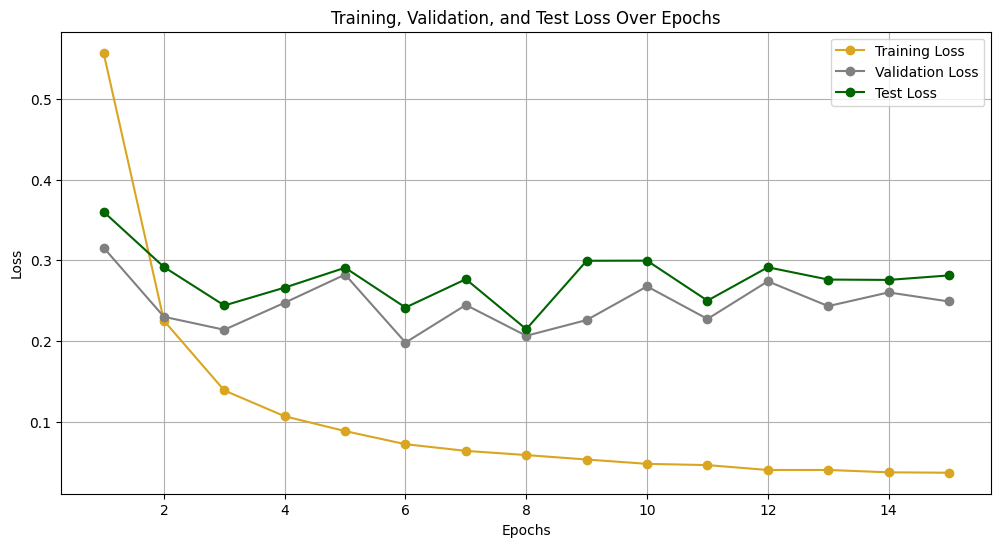

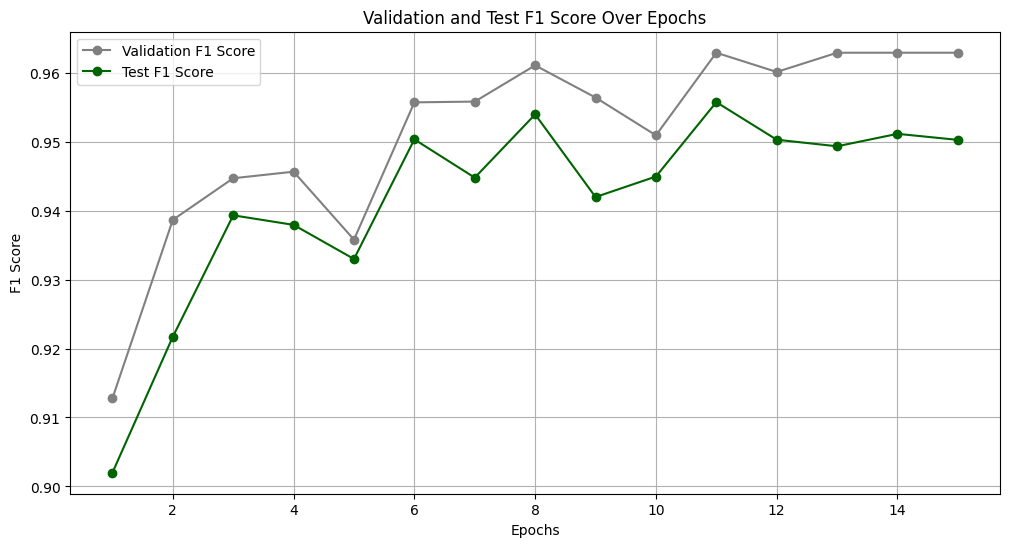

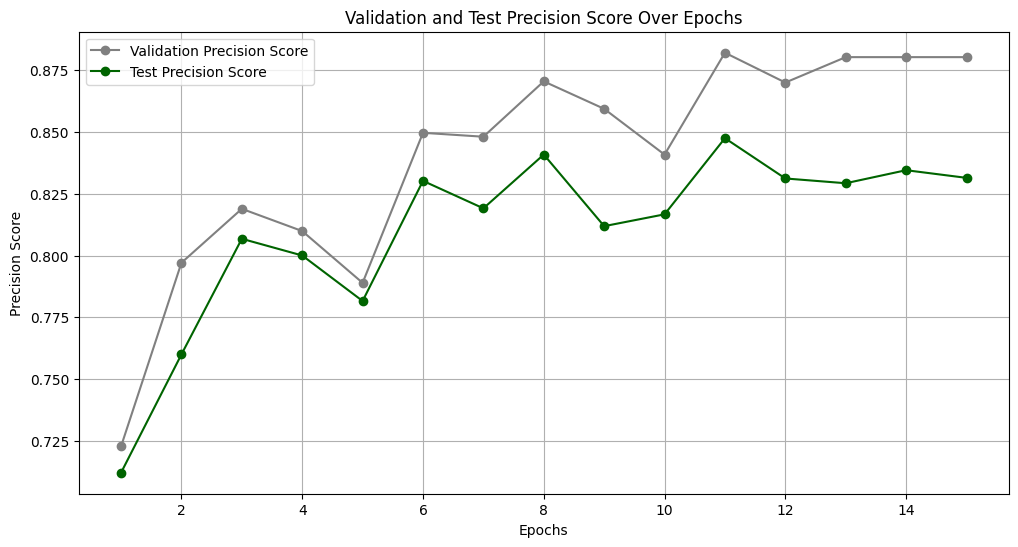

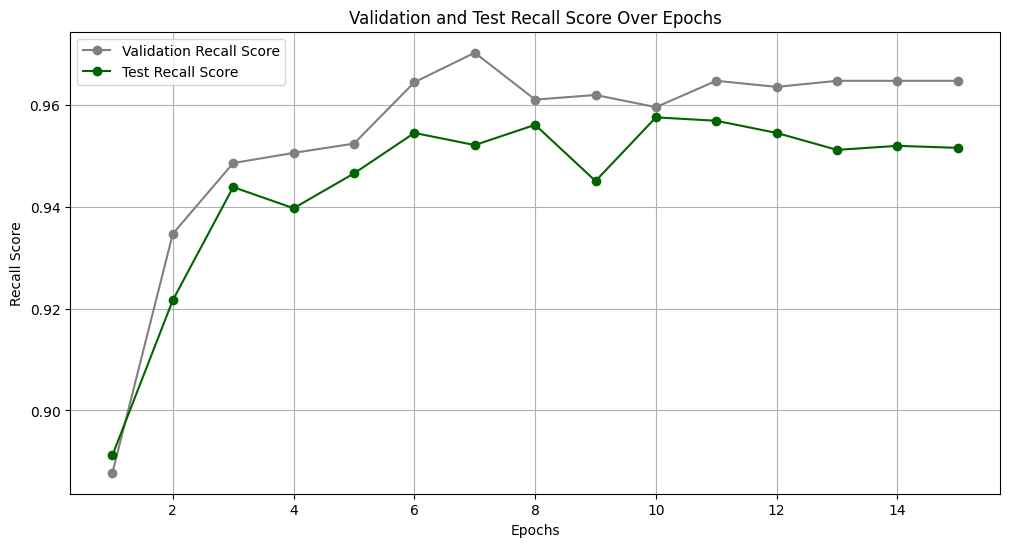

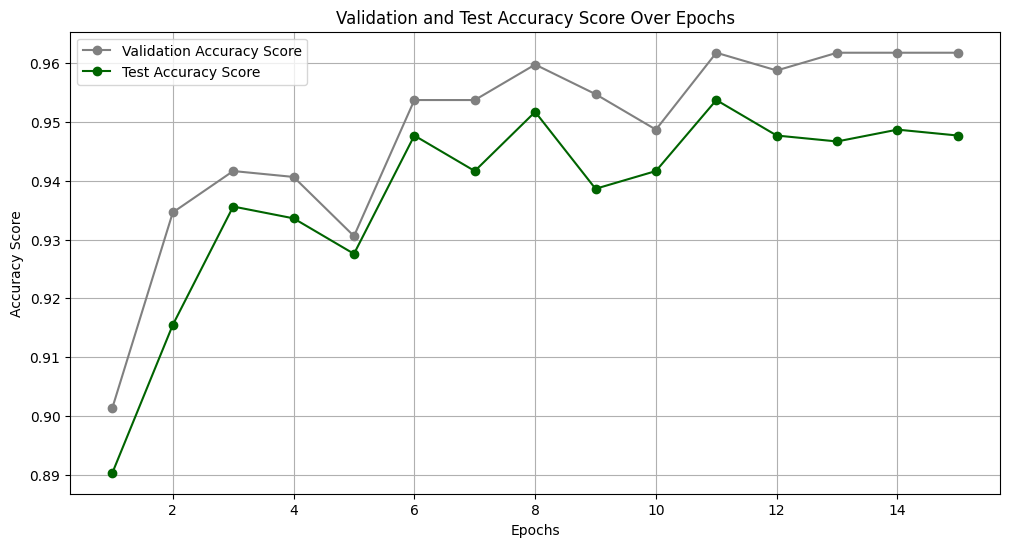

In [34]:
import matplotlib.pyplot as plt

# Menggunakan range(1, len(train_losses) + 1) untuk sumbu x
epochs = range(1, len(train_losses) + 1)

# Warna yang konsisten
colors = {
    'Training': 'goldenRod',
    'Validation': 'Gray',
    'Test': 'DarkGreen'
}

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color=colors['Training'])
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', color=colors['Validation'])
plt.plot(epochs, test_losses, label='Test Loss', marker='o', color=colors['Test'])
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, f1_scores, label='Validation F1 Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o', color=colors['Test'])
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_scores, label='Validation Precision Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_precision_scores, label='Test Precision Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, recall_scores, label='Validation Recall Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_recall_scores, label='Test Recall Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_scores, label='Validation Accuracy Score', marker='o', color=colors['Validation'])
plt.plot(epochs, test_accuracy_scores, label='Test Accuracy Score', marker='o', color=colors['Test'])
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Menggunakan training_status yang sudah ada untuk hasil evaluasi
results = []
for epoch_result in training_status:
    epoch_metrics = {
        'Epoch': epoch_result['epoch'],
        'Training Loss': epoch_result['Training Loss'],
        'Validation Loss': epoch_result['Valid. Loss'],
        'F1 Score (Val)': epoch_result['F1 Score'],
        'Precision Score (Val)': epoch_result['Precision Score'],
        'Recall Score (Val)': epoch_result['Recall Score'],
        'Accuracy Score (Val)': epoch_result['Accuracy Score'],
        'Test Loss': epoch_result['Test Loss'],
        'Test F1 Score': epoch_result['Test F1 Score'],
        'Test Precision Score': epoch_result['Test Precision Score'],
        'Test Recall Score': epoch_result['Test Recall Score'],
        'Test Accuracy Score': epoch_result['Test Accuracy Score']
    }
    results.append(epoch_metrics)

# Buat DataFrame dari hasil evaluasi
df = pd.DataFrame(results)

# Tampilkan DataFrame
print(df)


    Epoch  Training Loss  Validation Loss  F1 Score (Val)  \
0       1       0.557308         0.315848        0.912783   
1       2       0.225247         0.230112        0.938676   
2       3       0.138814         0.214017        0.944712   
3       4       0.106841         0.247569        0.945662   
4       5       0.088459         0.282424        0.935805   
5       6       0.072229         0.198219        0.955722   
6       7       0.063968         0.244769        0.955833   
7       8       0.058776         0.206551        0.961092   
8       9       0.053248         0.226090        0.956422   
9      10       0.047906         0.267760        0.950942   
10     11       0.046301         0.227418        0.962924   
11     12       0.040281         0.274068        0.960134   
12     13       0.040304         0.243324        0.962923   
13     14       0.037384         0.260323        0.962923   
14     15       0.036890         0.249056        0.962923   

    Precision Score (Va

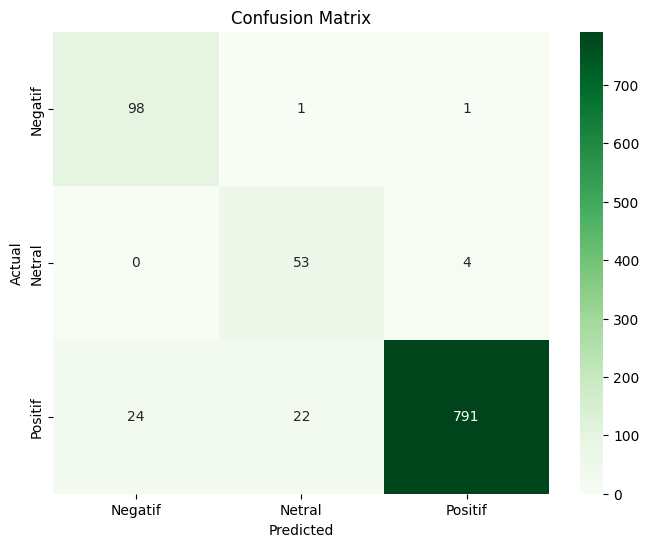

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluasi model pada data uji
test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)

# Membuat confusion matrix
confusion = confusion_matrix(test_true_vals, test_predictions.argmax(axis=1))

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix dengan palet hijau
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Set model ke mode evaluasi
model.eval()

# Inisialisasi list untuk menyimpan hasil prediksi dan label sebenarnya
all_predictions = []
all_true_vals = []

# Loop melalui batch data uji
for batch in tqdm(dataloader_test, desc='Evaluating'):
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)  # Menggunakan model untuk melakukan prediksi pada data uji
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1)  # Mengambil kelas dengan nilai probabilitas tertinggi
    all_predictions.extend(predictions.cpu().numpy())
    all_true_vals.extend(batch[2].cpu().numpy())

# Tampilkan hasil prediksi dan label yang sebenarnya
for i in range(len(all_predictions)):
    print(f'Prediksi: {all_predictions[i]}, Label Sebenarnya: {all_true_vals[i]}')


Evaluating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

Prediksi: 1, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 1
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 2, Label Sebenarnya: 2
Prediksi: 

In [39]:
import torch

# Kalimat yang ingin diprediksi
kalimat = 'aplikasinya sudah baik'

# Tokenisasi kalimat
encoded_data = tokenizer.encode_plus(
    kalimat,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids'].to(device)
attention_mask = encoded_data['attention_mask'].to(device)

# Melakukan prediksi tanpa perhitungan gradien
with torch.no_grad():
    model.eval()
    outputs = model(input_ids, attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Definisikan kamus label untuk konversi angka menjadi label sentimen
label_dict = {2: 'positif', 1: 'netral', 0: 'negatif'}
label_dict_inverse = {v: k for k, v in label_dict.items()}

# Nomor dan label sentimen prediksi
predicted_label_num = predictions[0]
predicted_sentiment = label_dict[predicted_label_num]

# Menampilkan hasil prediksi
print(f'Kalimat: {kalimat}')
print(f'Sentimen Prediksi: {predicted_sentiment} (Label: {predicted_label_num})')

Kalimat: aplikasinya sudah baik
Sentimen Prediksi: positif (Label: 2)
